In [45]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE as TSNE
from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

from matplotlib import cm
import matplotlib

c0 = matplotlib.colors.to_rgba('C2')
c1 = matplotlib.colors.to_rgba('C1')
blues = cm.get_cmap('Blues', 49+4)(np.linspace(0, 1, 49+4))
reds = cm.get_cmap('Reds', 69+5)(np.linspace(0, 1, 69+5))
class_colors = np.concatenate([np.array([c0, c1]), blues, reds[::-1]])
        
%matplotlib inline

# Parameters

In [2]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 5000
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 100
args.windows_per_epoch = int(1e6)
args.active_channels = 2
args.initial_learning_rate = 3e-4
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'GCAEC_AlltoAll_50sec'
simulated_dataset_path = '../data/all_timeseries_distinct_class_sim.csv'
experiment_dataset_path = '../data/all_timeseries_distinct_class_exp.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [3]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [4]:
simulated_dataset_description = pd.read_csv(simulated_dataset_path, skipinitialspace=True)
simulated_dataset_description

fp  cid                                        name
0                     simulation/07.11.19_nominal.npy    0                           Исправная система
1                    simulation/07.11.19_pga_leak.npy    1                          Утечка газа из ПГА
2          simulation/09.12.20_fluid_leak_0.600mm.npy    2              Утечка жидкости (D = 0.600 мм)
3          simulation/09.12.20_fluid_leak_0.625mm.npy    3              Утечка жидкости (D = 0.625 мм)
4          simulation/09.12.20_fluid_leak_0.650mm.npy    4              Утечка жидкости (D = 0.650 мм)
5          simulation/09.12.20_fluid_leak_0.675mm.npy    5              Утечка жидкости (D = 0.675 мм)
6          simulation/09.12.20_fluid_leak_0.700mm.npy    6              Утечка жидкости (D = 0.700 мм)
7          simulation/09.12.20_fluid_leak_0.725mm.npy    7              Утечка жидкости (D = 0.725 мм)
8          simulation/09.12.20_fluid_leak_0.750mm.npy    8              Утечка жидкости (D = 0.750 мм)
9          simulation/09.12.20_fluid_leak_0.775mm.npy    9              Утечка жидкости (D = 0.775 мм)
10         simulation/09.12.20_fluid_leak_0.800mm.npy   10              Утечка жидкости (D = 0.800 мм)
11         simulation/09.12.20_fluid_leak_0.825mm.npy   11              Утечка жидкости (D = 0.825 мм)
12         simulation/09.12.20_fluid_leak_0.850mm.npy   12              Утечка жидкости (D = 0.850 мм)
13         simulation/09.12.20_fluid_leak_0.875mm.npy   13              Утечка жидкости (D = 0.875 мм)
14         simulation/09.12.20_fluid_leak_0.900mm.npy   14              Утечка жидкости (D = 0.900 мм)
15         simulation/09.12.20_fluid_leak_0.925mm.npy   15              Утечка жидкости (D = 0.925 мм)
16         simulation/25.12.20_fluid_leak_0.940mm.npy   16              Утечка жидкости (D = 0.940 мм)
17         simulation/09.12.20_fluid_leak_0.950mm.npy   17              Утечка жидкости (D = 0.950 мм)
18         simulation/09.12.20_fluid_leak_0.975mm.npy   18              Утечка жидкости (D = 0.975 мм)
19         simulation/09.12.20_fluid_leak_1.000mm.npy   19              Утечка жидкости (D = 1.000 мм)
20         simulation/09.12.20_fluid_leak_1.025mm.npy   20              Утечка жидкости (D = 1.025 мм)
21         simulation/09.12.20_fluid_leak_1.050mm.npy   21              Утечка жидкости (D = 1.050 мм)
22         simulation/09.12.20_fluid_leak_1.075mm.npy   22              Утечка жидкости (D = 1.075 мм)
23         simulation/09.12.20_fluid_leak_1.100mm.npy   23              Утечка жидкости (D = 1.100 мм)
24         simulation/09.12.20_fluid_leak_1.125mm.npy   24              Утечка жидкости (D = 1.125 мм)
25         simulation/09.12.20_fluid_leak_1.150mm.npy   25              Утечка жидкости (D = 1.150 мм)
26         simulation/25.12.20_fluid_leak_1.160mm.npy   26              Утечка жидкости (D = 1.160 мм)
27         simulation/09.12.20_fluid_leak_1.175mm.npy   27              Утечка жидкости (D = 1.175 мм)
28         simulation/09.12.20_fluid_leak_1.200mm.npy   28              Утечка жидкости (D = 1.200 мм)
29         simulation/09.12.20_fluid_leak_1.225mm.npy   29              Утечка жидкости (D = 1.225 мм)
30         simulation/09.12.20_fluid_leak_1.250mm.npy   30              Утечка жидкости (D = 1.250 мм)
31         simulation/09.12.20_fluid_leak_1.275mm.npy   31              Утечка жидкости (D = 1.275 мм)
32         simulation/09.12.20_fluid_leak_1.300mm.npy   32              Утечка жидкости (D = 1.300 мм)
33         simulation/09.12.20_fluid_leak_1.325mm.npy   33              Утечка жидкости (D = 1.325 мм)
34         simulation/09.12.20_fluid_leak_1.350mm.npy   34              Утечка жидкости (D = 1.350 мм)
35         simulation/25.12.20_fluid_leak_1.365mm.npy   35              Утечка жидкости (D = 1.365 мм)
36         simulation/09.12.20_fluid_leak_1.375mm.npy   36              Утечка жидкости (D = 1.375 мм)
37         simulation/09.12.20_fluid_leak_1.400mm.npy   37              Утечка жидкости (D = 1.400 мм)
38         simulation/09.12.20_flu

In [5]:
experiment_dataset_description = pd.read_csv(experiment_dataset_path, skipinitialspace=True)
experiment_dataset_description

fp  cid                                       name
0                    experiment/06.11.19_nominal.npy    0                          Исправная система
1   experiment/14.12.20_fluid_leak_nominal_state.npy    0                          Исправная система
2    experiment/17.12.20_valve_set_error_nominal.npy    0                          Исправная система
3    experiment/31.12.20_valve_set_error_nominal.npy    0                          Исправная система
4                   experiment/06.11.19_pga_leak.npy    1                         Утечка газа из ПГА
5         experiment/14.12.20_fluid_leak_0.940mm.npy   16             Утечка жидкости (D = 0.940 мм)
6         experiment/14.12.20_fluid_leak_1.160mm.npy   26             Утечка жидкости (D = 1.160 мм)
7         experiment/14.12.20_fluid_leak_1.365mm.npy   35             Утечка жидкости (D = 1.365 мм)
8         experiment/14.12.20_fluid_leak_1.560mm.npy   44             Утечка жидкости (D = 1.560 мм)
9    experiment/17.12.20_valve_set_error_15.2bar.npy   55  Ошибка настройки клапана (Thr = 15.2 бар)
10   experiment/31.12.20_valve_set_error_15.2bar.npy   55  Ошибка настройки клапана (Thr = 15.2 бар)
11   experiment/17.12.20_valve_set_error_22.3bar.npy   56  Ошибка настройки клапана (Thr = 22.3 бар)
12   experiment/31.12.20_valve_set_error_22.3bar.npy   56  Ошибка настройки клапана (Thr = 22.3 бар)
13   experiment/17.12.20_valve_set_error_29.3bar.npy   57  Ошибка настройки клапана (Thr = 29.3 бар)
14   experiment/31.12.20_valve_set_error_29.3bar.npy   57  Ошибка настройки клапана (Thr = 29.3 бар)
15   experiment/17.12.20_valve_set_error_36.1bar.npy   83  Ошибка настройки клапана (Thr = 36.1 бар)
16   experiment/31.12.20_valve_set_error_36.1bar.npy   83  Ошибка настройки клапана (Thr = 36.1 бар)
17   experiment/17.12.20_valve_set_error_41.1bar.npy  104  Ошибка настройки клапана (Thr = 41.1 бар)
18   experiment/31.12.20_valve_set_error_41.1bar.npy  104  Ошибка настройки клапана (Thr = 41.1 бар)

In [6]:
Xsim = WindowDataset(simulated_dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xexp = WindowDataset(experiment_dataset_path, window_size=args.window_size, initial_shuffle=False, portion=args.portion, active_channels=args.active_channels, verbose=True)

../data/simulation/07.11.19_nominal.npy (3, 999200)
../data/simulation/07.11.19_pga_leak.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.600mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.625mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.650mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.675mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.700mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.725mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.750mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.775mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.800mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.825mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.850mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.875mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.900mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.925mm.npy (3, 999200)
../data/simul

In [7]:
# assert Xsim.class_names == Xexp.class_names
class_names = Xsim.class_names
class_names

{0: 'Исправная система',
 1: 'Утечка газа из ПГА',
 2: 'Утечка жидкости (D = 0.600 мм)',
 3: 'Утечка жидкости (D = 0.625 мм)',
 4: 'Утечка жидкости (D = 0.650 мм)',
 5: 'Утечка жидкости (D = 0.675 мм)',
 6: 'Утечка жидкости (D = 0.700 мм)',
 7: 'Утечка жидкости (D = 0.725 мм)',
 8: 'Утечка жидкости (D = 0.750 мм)',
 9: 'Утечка жидкости (D = 0.775 мм)',
 10: 'Утечка жидкости (D = 0.800 мм)',
 11: 'Утечка жидкости (D = 0.825 мм)',
 12: 'Утечка жидкости (D = 0.850 мм)',
 13: 'Утечка жидкости (D = 0.875 мм)',
 14: 'Утечка жидкости (D = 0.900 мм)',
 15: 'Утечка жидкости (D = 0.925 мм)',
 16: 'Утечка жидкости (D = 0.940 мм)',
 17: 'Утечка жидкости (D = 0.950 мм)',
 18: 'Утечка жидкости (D = 0.975 мм)',
 19: 'Утечка жидкости (D = 1.000 мм)',
 20: 'Утечка жидкости (D = 1.025 мм)',
 21: 'Утечка жидкости (D = 1.050 мм)',
 22: 'Утечка жидкости (D = 1.075 мм)',
 23: 'Утечка жидкости (D = 1.100 мм)',
 24: 'Утечка жидкости (D = 1.125 мм)',
 25: 'Утечка жидкости (D = 1.150 мм)',
 26: 'Утечка жидкости

In [8]:
Xsim_train = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

Xsim_test = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

Xexp_test = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0)

In [9]:
Xsim_test_classifier, test_labels_true = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

Xexp_test_classifier, experiment_labels_true = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0,
    return_true_labels=True)

# Model

In [10]:
input_shape = (Xsim.window_size, Xsim.active_channels)
embedding_size = 2
units = 32
kernel_size = 3

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, name):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1')(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory')(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=[c, gate], name=name)
#         m.summary()
        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

e, g1 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(inputs)
e, g2 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(e)
e, g3 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
e, g4 = conv_block(output_timesteps=10, output_channels=units, name=conv_block_name())(e)

d, g5 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
d, g6 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(d)
d, g7 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(d)
d, g8 = conv_block(output_timesteps=Xsim.window_size, output_channels=Xsim.active_channels, name='decoder_output')(d)

decoder_output = d

ef = kl.Flatten()(e)
embedding_output =kl.Dense(embedding_size, activation='linear', name='emb')(ef)
softmax_output = kl.Dense(Xsim.number_of_classes, activation='softmax', name='softmax_layer')(embedding_output)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

autoencoder_model = k.Model(inputs=inputs, outputs=[decoder_output, softmax_output, label_output], name='autoencoder')
encoder_model = k.Model(inputs=inputs, outputs=embedding_output, name='encoder')
classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output], name='classifier')

autoencoder_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 2)]    0                                            
__________________________________________________________________________________________________
cb_0 (Functional)               [(None, 100, 32), (N 660484      input_1[0][0]                    
__________________________________________________________________________________________________
cb_1 (Functional)               [(None, 50, 32), (No 12474       cb_0[0][0]                       
__________________________________________________________________________________________________
cb_2 (Functional)               [(None, 25, 32), (No 7099        cb_1[0][0]                       
________________________________________________________________________________________

# Train

In [11]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []
        
        self.experiment_loss = []
        self.experiment_ae_loss = []
        self.experiment_classifier_loss = []
        self.experiment_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

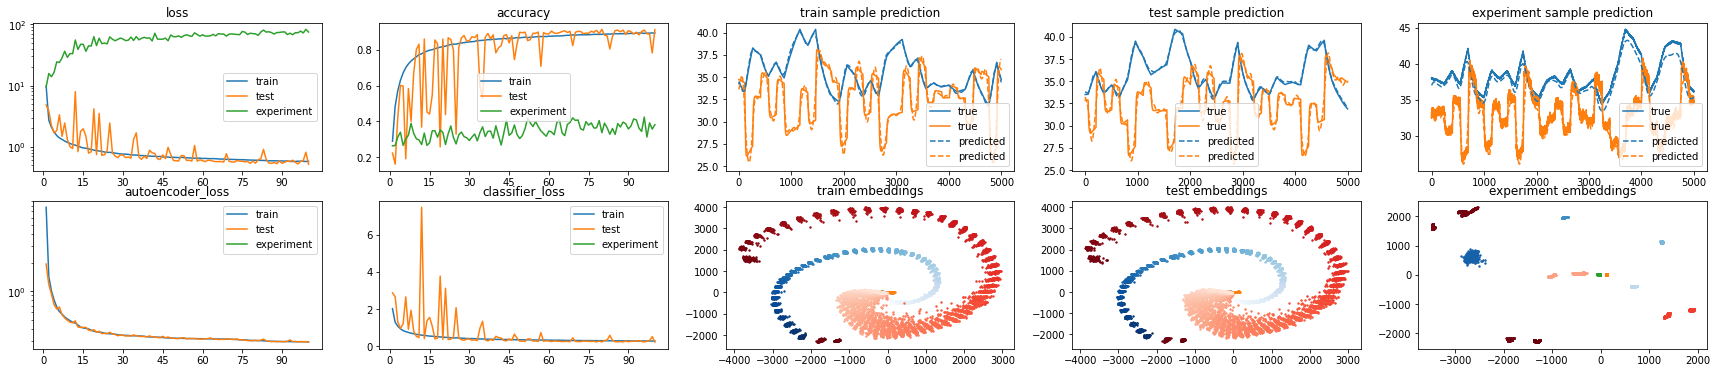

14:43:15.988300 100/100
train_loss: 0.5809243, test_loss:0.5225082, exp_loss:74.4961166
train_acc: 89.42, test_acc:91.35, test_acc:38.1428808
train_ae_loss: 0.2914124, test_ae_loss:0.2896584
7813/7813 [==============================] - 525s 67ms/step - loss: 0.5809 - decoder_output_loss: 0.2914 - softmax_layer_loss: 0.2895 - softmax_layer_sparse_categorical_accuracy: 0.8942
CPU times: user 14h 1min 1s, sys: 50min 18s, total: 14h 51min 19s
Wall time: 14h 43min 16s


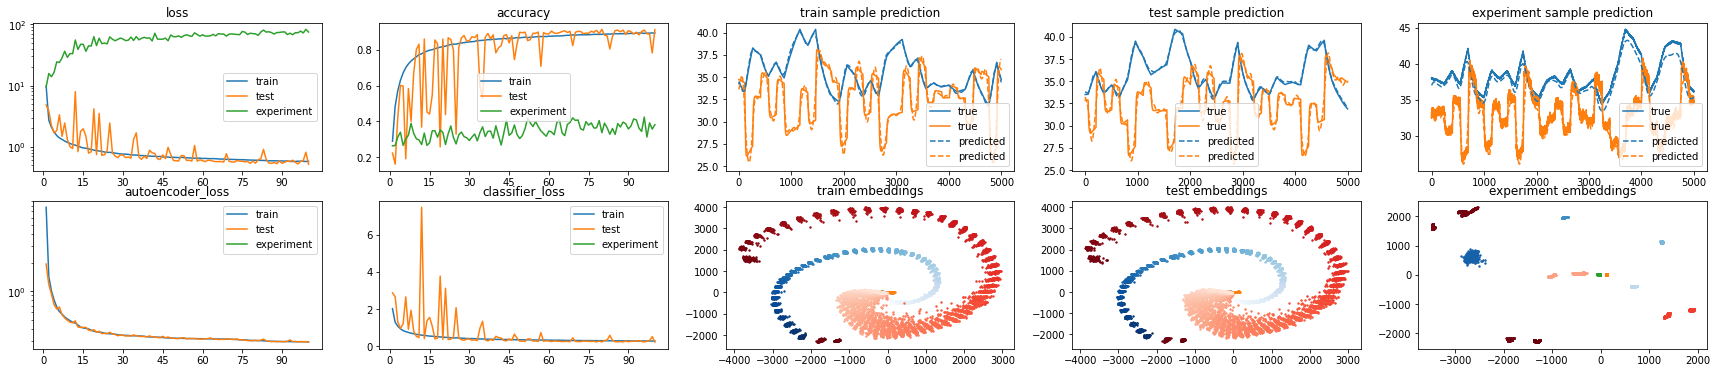

In [12]:
%%time 

start_time = dt.now()

fig, [[ax1, ax2, ax3, ax4, ax5], [ax10, ax20, ax30, ax40, ax50]] = plt.subplots(2,5, figsize=(30,6), gridspec_kw={'width_ratios':[0.2, 0.2, 0.2, 0.2, 0.2]})

samples = max(10000, int(min(Xsim.number_of_windows*0.1, Xexp.number_of_windows*0.1)))

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = Xsim_train.take(samples)
        self.test_sample = Xsim_test.take(samples)
        self.experiment_sample = Xexp_test.take(samples)
        self.train_sample_1 = list(Xsim_train.take(1).as_numpy_iterator())[0][0]
        self.test_sample_1 = list(Xsim_test.take(1).as_numpy_iterator())[0][0]
        self.experiment_sample_1 = list(Xexp_test.take(1).as_numpy_iterator())[0][0]
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_ae_loss, train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['decoder_output_loss'], train_results['softmax_layer_loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = autoencoder_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_ae_loss, test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['decoder_output_loss'], test_results['softmax_layer_loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        experiment_results = autoencoder_model.evaluate(self.experiment_sample.batch(args.batch_size), return_dict=True)
        experiment_loss, experiment_ae_loss, experiment_classifier_loss, experiment_classifier_acc = experiment_results['loss'], experiment_results['decoder_output_loss'], experiment_results['softmax_layer_loss'], experiment_results['softmax_layer_sparse_categorical_accuracy']
        

        predicted_train, _, _ = autoencoder_model.predict(self.train_sample_1[np.newaxis])
        predicted_test, _, _ = autoencoder_model.predict(self.test_sample_1[np.newaxis])
        predicted_experiment, _, _ = autoencoder_model.predict(self.experiment_sample_1[np.newaxis])
        predicted_train_z = encoder_model.predict(self.train_sample.batch(args.batch_size))
        predicted_test_z = encoder_model.predict(self.test_sample.batch(args.batch_size))
        predicted_experiment_z = encoder_model.predict(self.experiment_sample.batch(args.batch_size))
        
        self.history.train_loss.append(train_loss)
        self.history.train_ae_loss.append(train_ae_loss)
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_ae_loss.append(test_ae_loss)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
        
        self.history.experiment_loss.append(experiment_loss)
        self.history.experiment_classifier_acc.append(experiment_classifier_acc)
        
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
        ax5.cla()
        ax10.cla()
        ax20.cla()
        ax30.cla()
        ax40.cla()
        ax50.cla()
        
        ax1.set_title("loss")
        ax10.set_title("autoencoder_loss")
        ax20.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        ax10.set_yscale('log')
        
        ax3.set_title("train sample prediction")
        ax4.set_title("test sample prediction")
        ax5.set_title("experiment sample prediction")
        ax30.set_title("train embeddings")
        ax40.set_title("test embeddings")
        ax50.set_title("experiment embeddings")

        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.plot(range(1, len(self.history.experiment_loss)+1), self.history.experiment_loss, label='experiment')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.plot(range(1, len(self.history.experiment_classifier_acc)+1), self.history.experiment_classifier_acc, label='experiment')
        ax2.legend()
        
        ax10.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax10.plot(range(1, len(self.history.train_ae_loss)+1), self.history.train_ae_loss, label='train')
        ax10.plot(range(1, len(self.history.test_ae_loss)+1), self.history.test_ae_loss, label='test')
        ax10.plot(range(1, len(self.history.experiment_ae_loss)+1), self.history.experiment_ae_loss, label='experiment')
        ax10.legend()
        
        ax20.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax20.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax20.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax20.plot(range(1, len(self.history.experiment_classifier_loss)+1), self.history.experiment_classifier_loss, label='experiment')
        ax20.legend()
        
        Xtrain_sample = self.train_sample_1 
        ax3.plot(Xtrain_sample, label='true')
        ax3.set_prop_cycle(None)
        ax3.plot(predicted_train[0], label='predicted', linestyle='dashed')
        ax3.legend()
        
        Xtest_sample = self.test_sample_1
        ax4.plot(Xtest_sample, label='true')
        ax4.set_prop_cycle(None)
        ax4.plot(predicted_test[0], label='predicted', linestyle='dashed')
        ax4.legend()
        
        Xexp_sample = self.experiment_sample_1
        ax5.plot(Xexp_sample, label='true')
        ax5.set_prop_cycle(None)
        ax5.plot(predicted_experiment[0], label='predicted', linestyle='dashed')
        ax5.legend()

        for i in range(Xsim.number_of_source_files):
            x = predicted_train_z[np.arange(samples)%Xsim.number_of_source_files==i,0]
            y = predicted_train_z[np.arange(samples)%Xsim.number_of_source_files==i,1]
            class_label = Xsim.timeseries_class_labels[i]
            class_name = Xsim.class_names[class_label]
            class_color = class_colors[class_label]
            ax30.scatter(x, y, s=2, label=class_name, color=class_color)       
        
        for i in range(Xsim.number_of_source_files):
            x = predicted_test_z[np.arange(samples)%Xsim.number_of_source_files==i,0]
            y = predicted_test_z[np.arange(samples)%Xsim.number_of_source_files==i,1]
            class_label = Xsim.timeseries_class_labels[i]
            class_name = Xsim.class_names[class_label]
            class_color = class_colors[class_label]
            ax40.scatter(x, y, s=2, label=class_name, color=class_color)       

        for i in range(Xexp.number_of_source_files):
            x = predicted_experiment_z[np.arange(samples)%Xexp.number_of_source_files==i,0]
            y = predicted_experiment_z[np.arange(samples)%Xexp.number_of_source_files==i,1]
            class_label = Xexp.timeseries_class_labels[i]
            class_name = Xexp.class_names[class_label]
            class_color = class_colors[class_label]
            ax50.scatter(x, y, s=2, label=class_name, color=class_color)       
        

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}, exp_loss:{:.7f}".format(self.history.train_loss[-1], 
                                                                             self.history.test_loss[-1],
                                                                             self.history.experiment_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}, test_acc:{:.7f}".format(self.history.train_classifier_acc[-1]*100, 
                                                                           self.history.test_classifier_acc[-1]*100,
                                                                           self.history.experiment_classifier_acc[-1]*100))
        print("train_ae_loss: {:.7f}, test_ae_loss:{:.7f}".format(self.history.train_ae_loss[-1], 
                                                                  self.history.test_ae_loss[-1]
                                                                                     ))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

autoencoder_model.compile(optimizer=opt, 
                          loss={'decoder_output':losses.MSE,
                                'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'decoder_output':1.0, 'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

autoencoder_model.fit(Xsim_train.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

In [65]:
# autoencoder_model.save(models_path + model_name + '_ae.h5')
# encoder_model.save(models_path + model_name + '_e.h5')
# classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [20]:
%%time
#.take(3007455)
test_probs_predicted, test_labels_predicted = classifier_model.predict(Xsim_test_classifier.take(3007455).batch(args.batch_size))
test_labels_true = test_labels_true[:3007455]

CPU times: user 11min 7s, sys: 30.8 s, total: 11min 38s
Wall time: 12min 40s


In [21]:
%%time

experiment_probs_predicted, experiment_labels_predicted = classifier_model.predict(Xexp_test_classifier.batch(args.batch_size))

CPU times: user 27.2 s, sys: 1.16 s, total: 28.4 s
Wall time: 31.1 s


In [22]:
test_accuracy = skmetrics.accuracy_score(test_labels_true, test_labels_predicted)
test_balanced_accuracy = skmetrics.balanced_accuracy_score(test_labels_true, test_labels_predicted)
test_precision = skmetrics.precision_score(test_labels_true, test_labels_predicted, average='macro')
test_recall = skmetrics.recall_score(test_labels_true, test_labels_predicted, average='macro')
test_f1 = skmetrics.f1_score(test_labels_true, test_labels_predicted, average='macro')

experiment_accuracy = skmetrics.accuracy_score(experiment_labels_true, experiment_labels_predicted)
experiment_balanced_accuracy = skmetrics.balanced_accuracy_score(experiment_labels_true, experiment_labels_predicted)
experiment_precision = skmetrics.precision_score(experiment_labels_true, experiment_labels_predicted, average='macro')
experiment_recall = skmetrics.recall_score(experiment_labels_true, experiment_labels_predicted, average='macro')
experiment_f1 = skmetrics.f1_score(experiment_labels_true, experiment_labels_predicted, average='macro')

metrics = [test_accuracy, test_balanced_accuracy, test_precision, test_recall, test_f1, 
           experiment_accuracy, experiment_balanced_accuracy, experiment_precision, experiment_recall, experiment_f1]
print(metrics)

[0.9131079268018973, 0.9131079268018972, 0.9247455677035884, 0.9131079268018973, 0.9149689982429043, 0.4634955020505358, 0.35297501387931457, 0.7427985110725911, 0.4634955020505358, 0.5115252494404039]


/home/vlpr/miniconda3/envs/tfmkl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/vlpr/miniconda3/envs/tfmkl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vlpr/miniconda3/envs/tfmkl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(classification_report(test_labels_true, test_labels_predicted, target_names=class_names.values()))

                                            precision    recall  f1-score   support

                         Исправная система       0.12      0.42      0.18     24855
                        Утечка газа из ПГА       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.600 мм)       0.97      1.00      0.99     24855
            Утечка жидкости (D = 0.625 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.650 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.675 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.700 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.725 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.750 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.775 мм)       1.00      1.00      1.00     24855
            Утечка жидкости (D = 0.800 мм)       1.00      1.00      1.00  

''

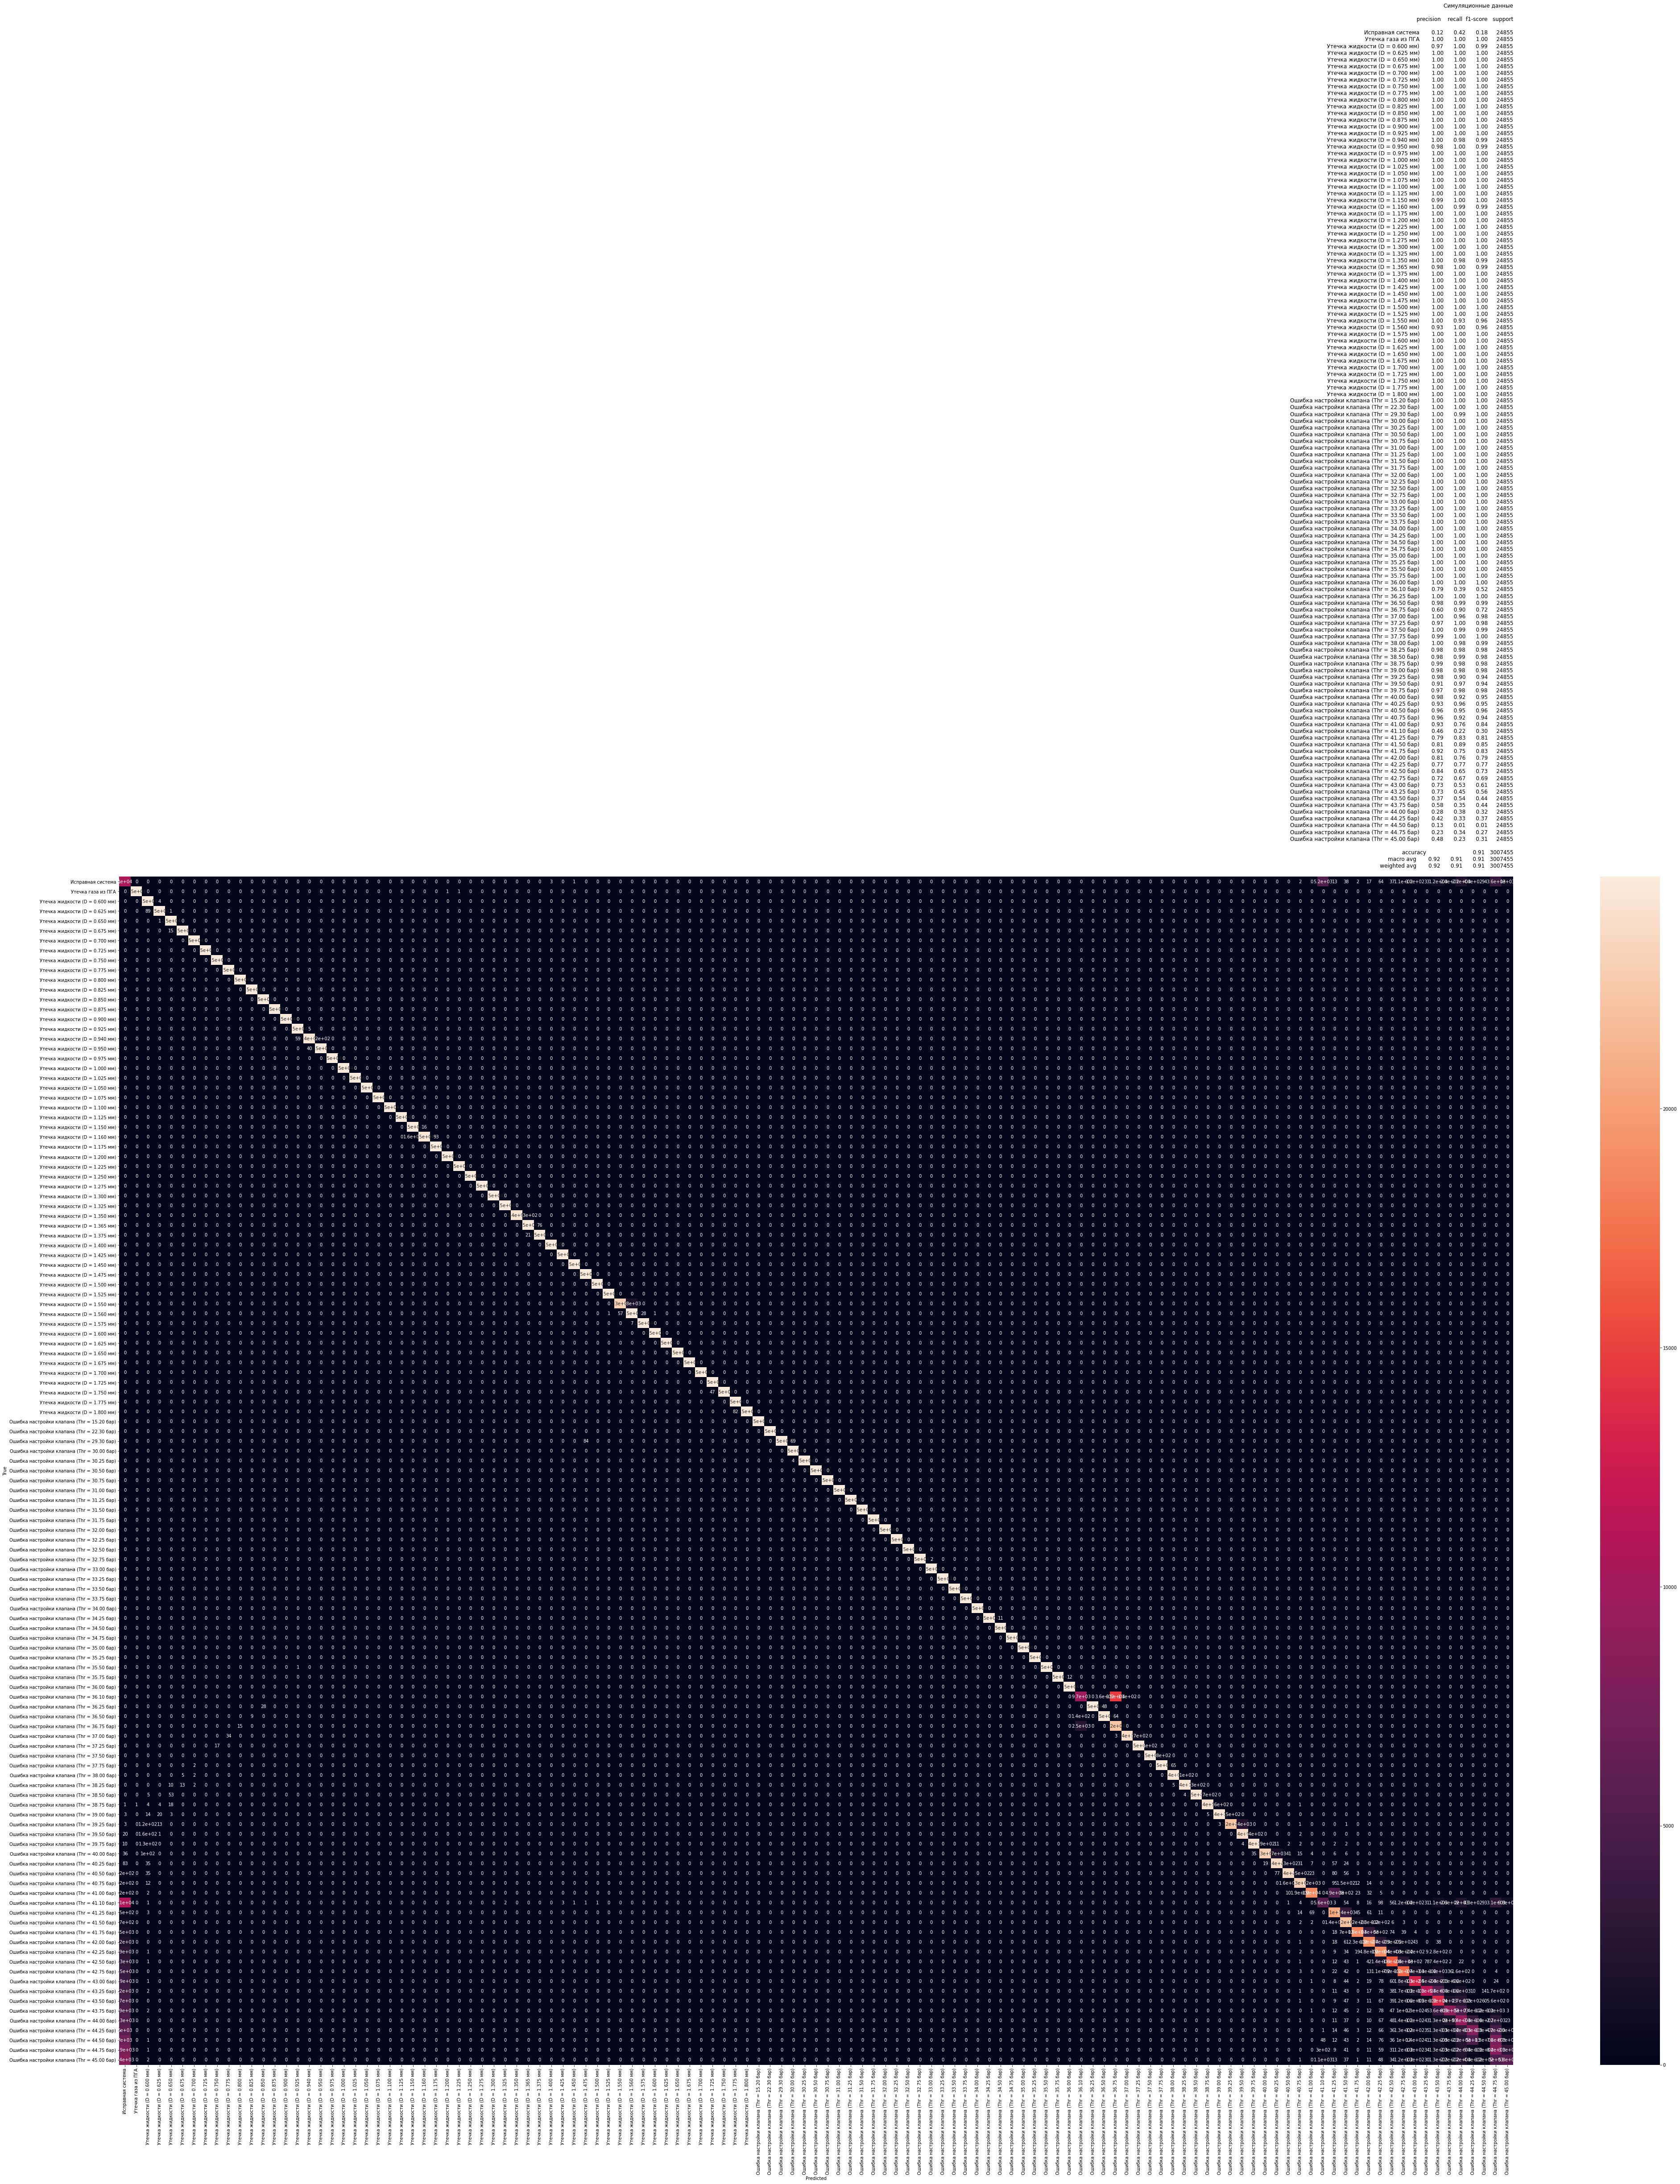

In [24]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10*7,7*7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=class_names.values()), loc="right")
,

In [25]:
print(classification_report(experiment_labels_true, experiment_labels_predicted, target_names=pd.Series(Xexp.timeseries_class_names).unique(), labels=pd.Series(Xexp.timeseries_class_labels).unique()))

                                           precision    recall  f1-score   support

                        Исправная система       1.00      0.35      0.52     30972
                       Утечка газа из ПГА       0.99      1.00      0.99     15972
           Утечка жидкости (D = 0.940 мм)       0.00      0.00      0.00      1000
           Утечка жидкости (D = 1.160 мм)       0.00      0.00      0.00      1000
           Утечка жидкости (D = 1.365 мм)       0.00      0.00      0.00      1000
           Утечка жидкости (D = 1.560 мм)       1.00      0.48      0.65      1000
Ошибка настройки клапана (Thr = 15.2 бар)       1.00      1.00      1.00     14000
Ошибка настройки клапана (Thr = 22.3 бар)       1.00      1.00      1.00     14000
Ошибка настройки клапана (Thr = 29.3 бар)       1.00      0.04      0.07     14000
Ошибка настройки клапана (Thr = 36.1 бар)       0.00      0.00      0.00     14000
Ошибка настройки клапана (Thr = 41.1 бар)       0.02      0.01      0.01     14000

  

/home/vlpr/miniconda3/envs/tfmkl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


''

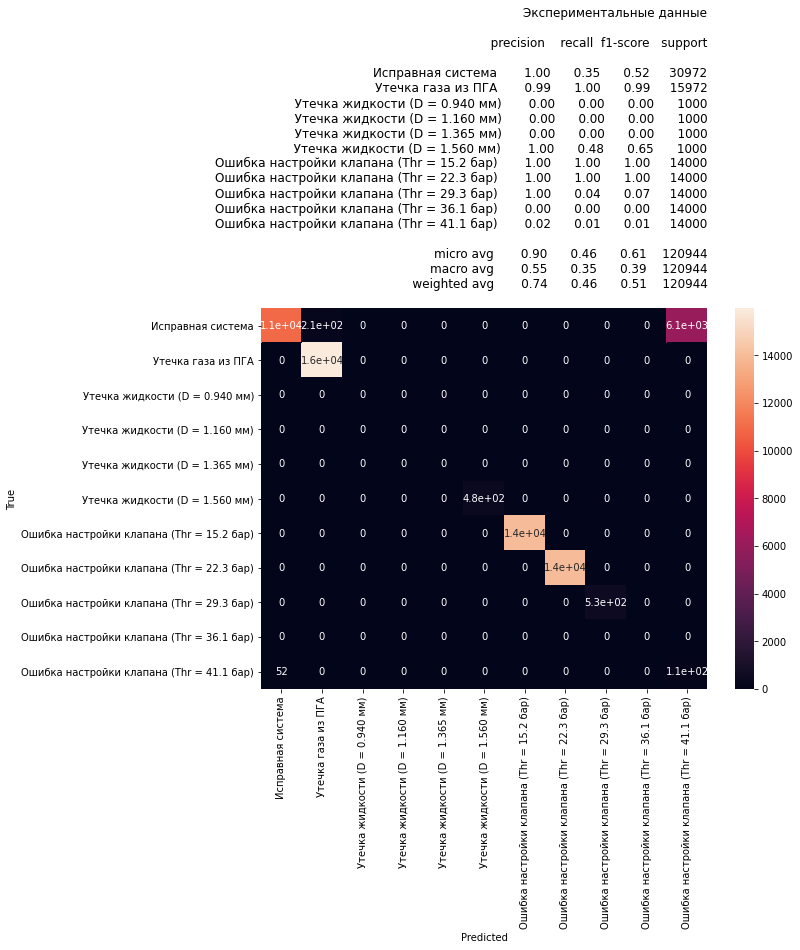

In [26]:
cf = confusion_matrix(experiment_labels_true, experiment_labels_predicted, normalize=None, labels=pd.Series(Xexp.timeseries_class_labels).unique())

df_cm = pd.DataFrame(cf, index = pd.Series(Xexp.timeseries_class_names).unique(), columns = pd.Series(Xexp.timeseries_class_names).unique())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Экспериментальные данные\n\n" + classification_report(experiment_labels_true, experiment_labels_predicted, target_names=pd.Series(Xexp.timeseries_class_names).unique(), labels=pd.Series(Xexp.timeseries_class_labels).unique()), loc="right")
,

In [27]:
embeddings_sim = encoder_model.predict(Xsim_test_classifier.take(3007455).batch(args.batch_size))

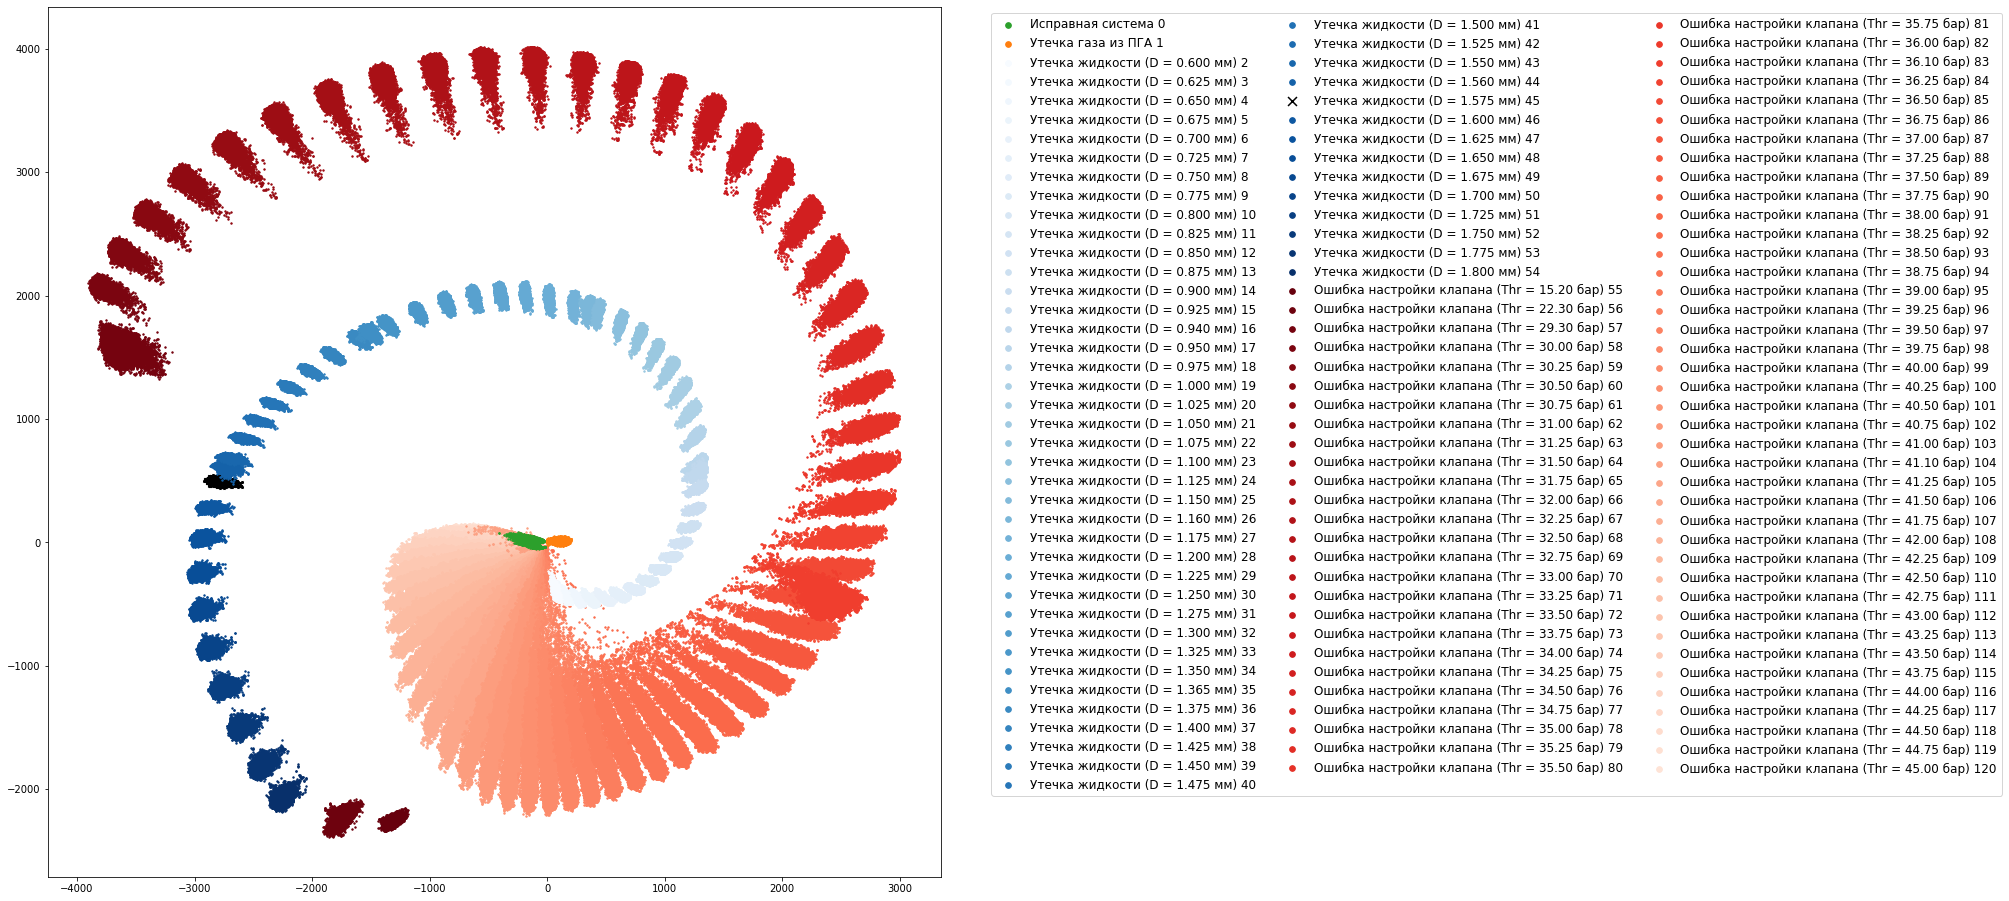

In [63]:
scale = 2
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

# ban_list = list(np.arange(99,112)) + [120]
ban_list = []
target_class = 45
    
for i in range(Xsim.number_of_source_files):
    class_label = Xsim.timeseries_class_labels[i]
    if not class_label in ban_list:
        x = embeddings_sim[np.arange(i, embeddings_sim.shape[0], Xsim.number_of_source_files),0]
        y = embeddings_sim[np.arange(i, embeddings_sim.shape[0], Xsim.number_of_source_files),1]    
        class_name = class_names[class_label]
        class_color = class_colors[class_label]
        if class_label==target_class:
            ax.scatter(x, y, s=5, label=class_name + ' {}'.format(class_label), color='black', zorder=Xsim.number_of_source_files-i, marker='x')
        else:
            ax.scatter(x, y, s=2, label=class_name + ' {}'.format(class_label), color=class_color, zorder=Xsim.number_of_source_files-i)
    
legend_without_duplicate_labels(ax)
# f

In [42]:
Xsim.number_of_source_files, len(class_colors)

(121, 129)

In [31]:
embeddings_exp = encoder_model.predict(Xexp_test_classifier.batch(args.batch_size))

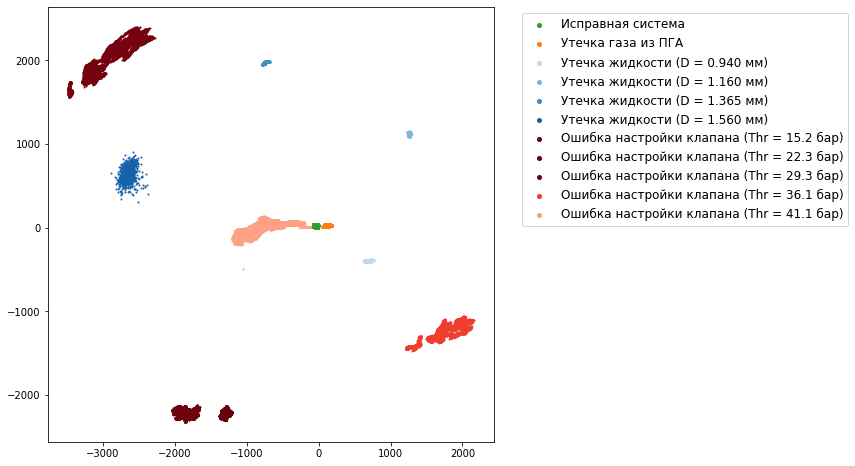

In [47]:
scale = 1
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

# def legend_without_duplicate_labels(ax):
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(*zip(*unique), markerscale=4, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)


for i, (class_label, class_name) in enumerate(zip(Xexp.class_names.keys(), Xexp.class_names.values())):
    class_color = class_colors[class_label]
#     print(class_label)
    x = embeddings_exp[experiment_labels_true==class_label,0]
    y = embeddings_exp[experiment_labels_true==class_label,1]    
    ax.scatter(x, y, s=1, label=class_name, color=class_color, alpha=1, zorder=Xexp.number_of_classes-i)       
    
ax.legend(loc='upper left', markerscale=4, fontsize=12, bbox_to_anchor=(1.05, 1),  ncol=1);

In [51]:
Xsim.number_of_windows*Xsim.window_size*Xsim.active_channels/1024/1024/1024/1024

1.09410685581679